In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Dropout, Flatten, Input, Reshape
from keras.callbacks import EarlyStopping
from scipy.optimize import newton
from scipy.integrate import odeint
from math import *
import time

2024-10-29 21:51:54.368718: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-29 21:51:54.378368: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-29 21:51:54.389965: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-29 21:51:54.393169: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-29 21:51:54.401630: I tensorflow/core/platform/cpu_feature_guar

In [2]:
#xy0 is [x0,y0] vxy0 is [vx0, vy0]
def projectile_motion(g, mu, xy0, vxy0, tt):
    # use a four-dimensional vector function vec = [x, y, vx, vy]
    def dif(vec, t):
        # time derivative of the whole vector vec
        v = sqrt(vec[2] ** 2 + vec[3] ** 2)
        return [vec[2], vec[3], -mu * v * vec[2], -g - mu * v * vec[3]]

    # solve the differential equation numerically
    vec = odeint(dif, [xy0[0], xy0[1], vxy0[0], vxy0[1]], tt)
    return vec[:, 0], vec[:, 1], vec[:, 2], vec[:, 3]  # return x, y, vx, vy

def makepath(angle, vel):
    alpha0 = radians(angle)
    xy = [0.0, 0.0]
    vxy =[vel * cos(alpha0), vel* sin(alpha0)]
    #use newton to find the zero of the function for the y component of the velocity [3][1] starting from 0
    T_peak = newton(lambda t: projectile_motion(g, mu, (xy[0], xy[1]), (vxy[0], vxy[1]), [0, t])[3][1], 0)
    y_peak = projectile_motion(g, mu, (xy[0], xy[1]), (vxy[0], vxy[1]), [0, T_peak])[1][1]
    #use newton to find the zero of the y position starting from 2*T_peak
    T = newton(lambda t: projectile_motion(g, mu, (xy[0], xy[1]), (vxy[0], vxy[1]), [0, t])[1][1], 2 * T_peak)
    #print(T, 2*T_peak)
    t = np.linspace(0, T, 101)
    x, y, vx, vy = projectile_motion(g, mu, (xy[0], xy[1]), (vxy[0], vxy[1]), t)
    return x, y, t

# Parameters of projectile (modelled after a baseball)
g       = 9.81         # Acceleration due to gravity (m/s^2)
rho_air = 1.29         # Air density (kg/m^3)
v0      = 44.7         # Initial velocity (m/s)
alpha0  = radians(75)  # Launch angle (deg.)
m       = 0.145        # Mass of projectile (kg)
cD      = 0.5          # Drag coefficient (spherical projectile)
r       = 0.0366       # Radius of projectile (m)
mu = 0.5 * cD * (pi * r ** 2) * rho_air / m

I0000 00:00:1730249516.961647   49292 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730249516.987942   49292 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730249516.989065   49292 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1730249516.990946   49292 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

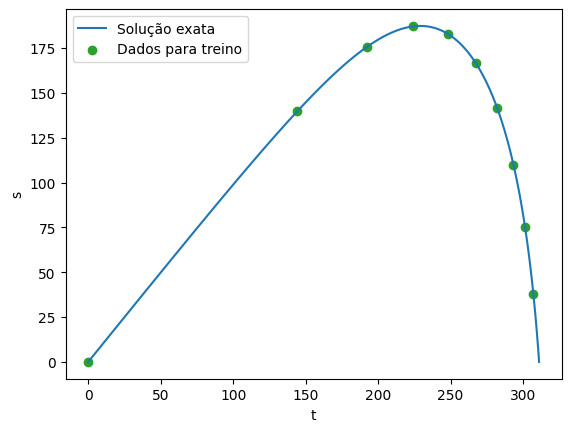

In [3]:

X,Y,T = makepath(45,500)
V0 = tf.expand_dims(tf.ones(101)*500,1)
Theta0 = tf.expand_dims(tf.ones(101)*45,1)
X = tf.convert_to_tensor(X,dtype='float32')
X = tf.expand_dims(X, 1)
Y = tf.convert_to_tensor(Y,dtype='float32')
Y = tf.expand_dims(Y, 1)
T = tf.convert_to_tensor(T,dtype='float32')
T = tf.expand_dims(T, 1)
Traj = tf.concat([X,Y],axis=1)
x_data = tf.concat([T,Theta0, V0],axis=1)[0:100:10]
y_data = Traj[0:100:10]
plt.figure()
plt.plot(X, Y, label="Solução exata")
plt.scatter(y_data[:,0],y_data[:,1], color="tab:green", label="Dados para treino")
plt.xlabel('t')
plt.ylabel('s')
plt.legend()
plt.show()

In [ ]:
x_phys = tf.stack([tf.linspace(0.0,15.0,150),tf.ones(150,dtype=tf.float32)*tf.random.uniform([1],minval=10,maxval=85,dtype=tf.float32),tf.ones(150,dtype=tf.float32)*tf.random.uniform([1],minval=100,maxval=500,dtype=tf.float32)],axis=1)

In [ ]:
x_phys = tf.stack([tf.linspace(0,15,150),tf.ones(150)*tf.random.uniform(shape=[1],minval=10,maxval=85),tf.ones(150)*tf.random.uniform([1],minval=100,maxval=500)],axis=1)

InvalidArgumentError: cannot compute Pack as input #1(zero-based) was expected to be a double tensor but is a float tensor [Op:Pack] name: stack

In [11]:
start_time = time.time()

# x da EDO, com 30 pontos
x_phys = tf.linspace(0,15,150)
x_phys = tf.cast(x_phys, tf.float64)
x_phys = tf.expand_dims(x_phys, 1)

#hiperparametros
tf.random.set_seed(5) #fixa a semente para cada teste ser igual
learning_rate = 1e-3
epochs = 500000 #uns 780 seg no colab
k_phy_loss1=(1e-2) # coloque zero nesta grandeza para uma FF!
k_phy_loss2=(1e-2)

# Arquiteruta do modelo neural, usando o keras
input_dim = 3
hidden_dim = 32
hidden_dim2 = 32
output_dim = 2

model_keras=tf.keras.Sequential([
    tf.keras.layers.Dense(hidden_dim, input_dim=input_dim, use_bias=1,activation='tanh'),
    tf.keras.layers.Dense(hidden_dim2, activation='tanh'),
    tf.keras.layers.Dense(output_dim, activation='linear')
],name='rede_para_PINN')
model_keras.summary()

Model: "rede_para_PINN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 32)                128       
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1250 (4.88 KB)
Trainable params: 1250 (4.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Para testar só mse
model_keras.compile(optimizer="adam",loss="mse")
model_keras.fit(x_data,y_data,epochs=1,verbose=1)

In [14]:
# Define constants
epsilon = 1e-7  # Small constant to avoid division by zero
learning_rate = 0.00005

# Define optimizer
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

@tf.function
def training_step(x_data, y_data):
    # Generate physical input data
    t_phys = tf.linspace(0.0, 15.0, 150)
    V0_phys = tf.random.uniform([1], minval=100.0, maxval=500.0, dtype=tf.float32)
    Theta0_phys = tf.random.uniform([1], minval=10.0, maxval=85.0, dtype=tf.float32)
    tensor_V0_phys = tf.ones(150, dtype=tf.float32) * V0_phys
    tensor_Theta0_phys = tf.ones(150, dtype=tf.float32) * Theta0_phys
    x_phys = tf.stack([t_phys, tensor_Theta0_phys, tensor_V0_phys], axis=1)

    # Convert input data to tensors
    batch_X = tf.convert_to_tensor(x_data, dtype=tf.float32)
    batch_y = tf.convert_to_tensor(y_data, dtype=tf.float32)

    with tf.GradientTape(persistent=True) as tape:
        # Forward pass for data points
        yh = model_keras(batch_X)
        data_loss = tf.reduce_mean(tf.square(yh - batch_y))

        # Forward pass for physical constraints
        yhp = model_keras(x_phys)
        with tf.GradientTape() as t1:
            t1.watch(x_phys)
            yhp = model_keras(x_phys)
        dx = t1.batch_jacobian(yhp, x_phys)[:, :, 0]

        with tf.GradientTape() as t2:
            t2.watch(x_phys)
            dx2 = t2.batch_jacobian(dx, x_phys)[:, :, 0]

        vx = dx[:, 0]
        vy = dx[:, 1]
        dvx = dx2[:, 0]
        dvy = dx2[:, 1]
        V = tf.sqrt(tf.square(vx) + tf.square(vy))

        physics1 = tf.reduce_mean(tf.square(dvx + mu * vx * V))
        physics2 = tf.reduce_mean(tf.square(dvy + g + mu * vy * V))

        Phys_loss1 = k_phy_loss1 * physics1
        Phys_loss2 = k_phy_loss2 * physics2
        Conds_iniciais1 = k_phy_loss1*tf.square(V[0] - V0_phys)
        Conds_iniciais2 = k_phy_loss1*tf.square(tf.math.acos(tf.clip_by_value(vx[0] / (V[0] + epsilon), -1.0, 1.0)) - Theta0_phys)

        # Total loss
        loss = data_loss + Phys_loss1 + Phys_loss2 + Conds_iniciais1 + Conds_iniciais2

    # Compute gradients
    gradients = tape.gradient(loss, model_keras.trainable_variables)
    gradients = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gradients]  # Gradient clipping

    # Apply gradients
    optimizer.apply_gradients(zip(gradients, model_keras.trainable_variables))

    return Phys_loss1+Phys_loss2,Conds_iniciais1+Conds_iniciais2,data_loss,loss

# Example usage (ensure model_keras is defined and x_data, y_data are available):
# data_loss, Phys_loss1, Phys_loss2, Conds_iniciais1, Conds_iniciais2 = training_step(x_data, y_data)
# print(f"Data Loss: {data_loss.numpy()}, Phys Loss 1: {Phys_loss1.numpy()}, Phys Loss 2: {Phys_loss2.numpy()}, Initial Cond 1: {Conds_iniciais1.numpy()}, Initial Cond 2: {Conds_iniciais2.numpy()}")


In [ ]:
for i in range(1000):
    loss =  training_step(x_data,y_data)
    tf.print(i,loss)

In [ ]:
h_loss=[]
h_data_loss=[]
h_Phys_loss=[]
for epoch in range(epochs):
    loss = training_step(x_data,y_data)
    l1,l2,l3,l4 = loss
    h_loss.append(l4)
    h_data_loss.append(l3)
    h_Phys_loss.append(l1)
    if ((epoch+1)%500==0):
      print(f"Epoch {epoch + 1}/{epochs}, Loss: {l4}, Data Loss: {l3}, Physics Loss: {l1}, Initial_Conds: {l2}")
print("--- %s seconds ---" % (time.time() - start_time))

Epoch 500/500000, Loss: [63989.86], Data Loss: 37880.375, Physics Loss: 0.9623599052429199, Initial_Conds: [26108.521]
Epoch 1000/500000, Loss: [130151.66], Data Loss: 37249.40234375, Physics Loss: 0.9623610377311707, Initial_Conds: [92901.29]
Epoch 1500/500000, Loss: [47644.99], Data Loss: 36839.8046875, Physics Loss: 0.9623607993125916, Initial_Conds: [10804.224]
Epoch 2000/500000, Loss: [155647.44], Data Loss: 36520.984375, Physics Loss: 0.9623610377311707, Initial_Conds: [119125.484]
Epoch 2500/500000, Loss: [67229.8], Data Loss: 36225.09375, Physics Loss: 0.9623609185218811, Initial_Conds: [31003.746]
Epoch 3000/500000, Loss: [102437.484], Data Loss: 35940.7890625, Physics Loss: 0.9623610377311707, Initial_Conds: [66495.734]
Epoch 3500/500000, Loss: [107602.09], Data Loss: 35665.39453125, Physics Loss: 0.9623612761497498, Initial_Conds: [71935.74]
Epoch 4000/500000, Loss: [190833.45], Data Loss: 35392.77734375, Physics Loss: 0.9623610377311707, Initial_Conds: [155439.72]
Epoch 450

In [ ]:
loss = training_step(x_data,y_data)
tf.print(loss)

[178319.562]


In [ ]:
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)
@tf.function
def training_step(x_data,y_data):
    t_phys = tf.linspace(0.0, 15.0, 150)
    V0_phys = tf.random.uniform([1], minval=100.0, maxval=500.0, dtype=tf.float32)
    Theta0_phys = tf.random.uniform([1], minval=10.0, maxval=85.0, dtype=tf.float32)
    tensor_V0_phys = tf.ones(150, dtype=tf.float32) * V0_phys
    tensor_Theta0_phys = tf.ones(150, dtype=tf.float32) * Theta0_phys
    x_phys = tf.stack([t_phys,tensor_Theta0_phys,tensor_V0_phys],axis=1)

    batch_X = x_data
    batch_y = tf.convert_to_tensor(y_data, dtype='float32')
    with tf.GradientTape() as tape:
        yh = model_keras(batch_X) #calcula as saidas da rede nos pontos "experimentais"
        data_loss = tf.reduce_mean(tf.square(yh - batch_y))
        with tf.GradientTape() as t2:
            t2.watch(x_phys)
            with tf.GradientTape() as t1:
                t1.watch(x_phys)
                yhp = model_keras(x_phys) #calcula as saidas da rede nos pontos escolhidos para ajustar a EDO
            dx  = tf.reshape(t1.batch_jacobian(yhp, x_phys),(-1,2)) # calcula dy/dx que é igual a ds/dt
        dx2 = tf.reshape(t2.batch_jacobian(dx, x_phys),(-1,2)) # calcula d^2y/dx^2 que é igual a d^2s/dt^2
        vx = dx[:,0]
        vy = dx[:,1]
        dvx = dx2[:,0]
        dvy = dx2[:,1]
        V = tf.sqrt(tf.square(vx)+tf.square(vy))
        physics1 = tf.reduce_mean(tf.square(dvx+mu*vx*V))
        physics2 = tf.reduce_mean(tf.square(dvy+g+mu*vy*V))

        Phys_loss1 = k_phy_loss1*physics1
        Phys_loss2 = k_phy_loss2*physics2
        data_loss = tf.cast(data_loss, "float64")
        Conds_iniciais1 =  tf.square(V[0]-V0_phys)
        Conds_iniciais2 = tf.square(tf.math.acos(vx[0]/V[0]-Theta0_phys))
        loss = Phys_loss1 + Phys_loss2 + data_loss
    gradients = tape.gradient(loss, model_keras.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_keras.trainable_variables))

    return Phys_loss1, Phys_loss2, data_loss, loss


In [ ]:
loss = training_step(x_data,y_data)

In [ ]:
h_loss=[]
h_data_loss=[]
h_Phys_loss=[]
for epoch in range(epochs):
    loss = training_step(x_data,y_data)
    l1,l2,l3,l4 = loss
    h_loss.append(l4)
    h_data_loss.append(l3)
    h_Phys_loss.append(l1+l2)
    if ((epoch+1)%500==0):
      print(f"Epoch {epoch + 1}/{epochs}, Loss: {l4}, Data Loss: {l3}, Physics Loss: {l1+l2}")
print("--- %s seconds ---" % (time.time() - start_time))

KeyboardInterrupt: 

Text(0, 0.5, 'loss')

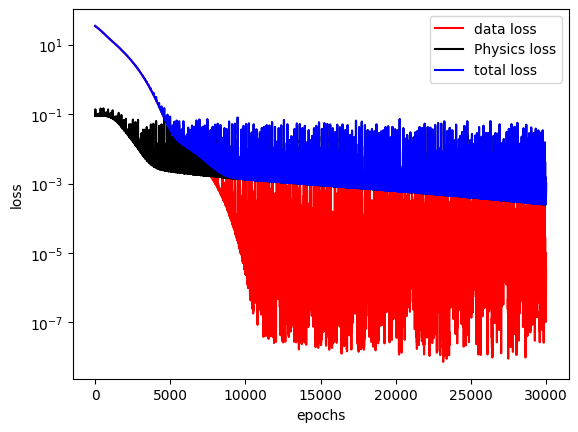

In [ ]:
plt.figure()
plt.plot(h_data_loss,'r',label='data loss');
plt.plot(h_Phys_loss,'k',label='Physics loss');
plt.plot(h_loss,'b',label='total loss');
plt.yscale('log')
plt.legend()
plt.xlabel('epochs');plt.ylabel('loss')



In [ ]:
prev = np.array(model_keras.predict(T)).reshape(-1,2)

4/4 [==============================] - 0s 2ms/step


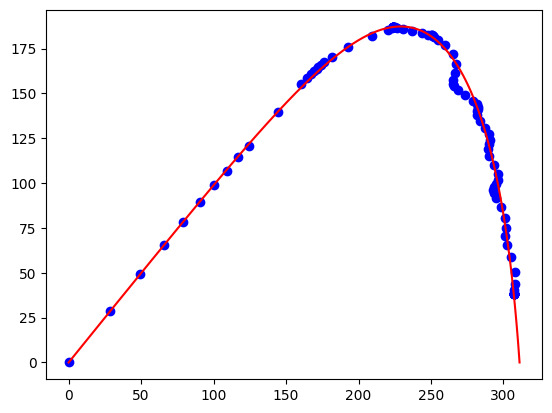

In [ ]:
plt.plot(prev[:,0],prev[:,1],"bo")
#plt.plot(y_data[:,0],y_data[:,1],"ro")
plt.plot(X,Y,"r-")